# Yoga Poses Image Classifier with Keras and TensorFlow

In this notebook I will load a custom dataset containing images of people performing 24 different yoga poses and train a neural network to classify the pose in a given image. Then I will compare the performance of that model against a pre-trained Inception model and observe whether transfer learning offers a benefit in this task.

I am using Keras and TensorFlow frameworks for this exercise as practice for the Google TensorFlow Developer Certification. 

## Data Loading & Preprocessing

The images in this dataset were collected by scraping Google Images (See the Web Scraper Notebook in this project folder).  I attempted to collect images of a single person performing the specified pose from a variety of positions and include a diversity of gender, age, body-type, race, and settings. While there is some diversity in the data it is likely not equal among all poses, and in all cases there is bias toward fit females. In some photos there are multiple people and some images showing computer-rendered humans are in the dataset. For each pose there are also different orientations represented (straight on, from side, etc), however the bias is towards one or a few common angles. The raw images come in a variety of sizes and resolutions. I manually cleaned up the data to balance out the number of images per pose, remove low quality images, and separate into training and test sets. Some images appeared multiple times, and in some cases I deleted them and in others I introduced agumentations such as horizontal flips, cropping, and adding color filters. Overall the dataset is not great quality, but should suffice for this exercise.

The images are saved in directories with the folder names indicating the pose (class label). There are 24 different poses in this dataset:
* Bridge
* Cat
* Chair
* Childs
* Cobra/Updog
* Cow
* Crane/Crow
* Downward Dog
* Half Moon
* Headstand
* Mountain
* Plank
* Plough
* Seated Forward Fold
* Seated Mudra
* Side Angle
* Side Plank
* Standing Bend
* Tree
* Triangle
* Warrior One
* Warrior Two
* Wheel
* Yogic Squat

Some of these pose classes group similar poses together, this was primarily due to a lack of images found for the specific pose. Some of these pose classes are also have more subtle distinctions in positioning. It will be interesting to observe how the model handles these cases and whether it is detrimental to overall performance.

In [1]:
import os
import tensorflow as tf

# following two lines needed to avoid issue on my system. See, https://github.com/tensorflow/tensorflow/issues/43174
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import display
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

First, I am defining variables for the image data and model hyperparameters.

In [22]:
# Hyperparameters
TRAIN_DIR = 'Images/training_set'
TEST_DIR = 'Images/test_set'
VAL_SPLIT = 0.15
IMAGE_SIZE = 256
IMAGE_CHAN = 3
BATCH_SIZE = 64
CLASSES = os.listdir(TRAIN_DIR)
NUM_CLASSES = len(CLASSES)
EPOCHS = 30

The code below defines a data processing pipeline that will load the data from the directories and apply some augmentations to the images before they gets passed to the model.  In addition to the standard rescaling and resizing I will include a random horizontal flip, zoom, and shear augmentations to help the model generalize to new images.  The shear operation could be a problem for some cases where the angle is important for identifying the pose, but I suspect this is mostly an edge case and overall it should benefit the task.

In [23]:
# Create an Image Data Generator for the training and validation sets
train_gen = ImageDataGenerator(
                                rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.1,
                                fill_mode='nearest',
                                horizontal_flip=True,
                                validation_split=VAL_SPLIT
                                )

# Create Data Loaders for training and validation sets
train_generator = train_gen.flow_from_directory(
                                TRAIN_DIR,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical',
                                subset='training')

val_generator = train_gen.flow_from_directory(
                                TRAIN_DIR,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical',
                                subset='validation')

# Create Image Data Generator and Data Loader for test set

test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_directory(
                                TEST_DIR,
                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                batch_size=BATCH_SIZE,
                                class_mode='categorical')

Found 4678 images belonging to 24 classes.
Found 810 images belonging to 24 classes.
Found 1199 images belonging to 24 classes.


The training set contains about 5.5k images with between 200 and 250 images per class. I sample a validation set from the training data. The test set contains 1.2k images with 50 images per class.

Below we see that the classes are not perfectly balanced. This could lead to bias in the model predictions. I am willing to accept the imbalance for this exercise, and leave it to a future experiment to compare the results with a weighted sampling that balances the classes in training.

In [24]:
def image_count_by_class(data):
    class_count = {}
    
    for i in data.classes:
        if i in class_count.keys():
            class_count[i] += 1
        else:    
            class_count[i] = 1
    
    class_pct = {k: v/len(data.classes) for k,v in class_count.items()}
    return class_count, class_pct

In [25]:
train_class_count, train_class_pct = image_count_by_class(train_generator)

<BarContainer object of 24 artists>

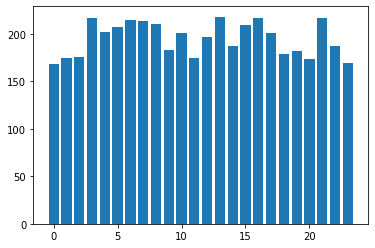

In [26]:
plt.bar(train_class_count.keys(), train_class_count.values())

Now lets view a sample of the images.

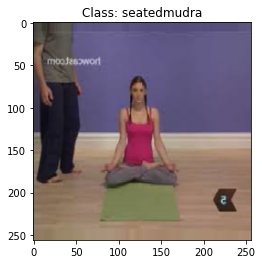

In [40]:
for i in range(15):
    display.clear_output(wait=True)
    plt.imshow(train_generator[0][0][i])
    plt.title(f"Class: {CLASSES[np.argmax(train_generator[0][1][i])]}")
    plt.show()
    time.sleep(0.5)

## Building a Neural Network 

As a starting point I will build a fairly standard convolutional neural network consisting of 5 layers of a 2D Convolution followed with MaxPooling feeding into 2 fully connected layers for final class prediction. I introduce dropout layers with the hope that it improves generalization and prevents overfitting.

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHAN)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 28, 28, 64)       

### Writing a Callback for Early Stopping

I will stop training if we reach 99% accuracy on the training set.

In [29]:
class earlyStopAcc(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.99:
            self.model.stop_training = True
            print('Reached 99% accuracy, stopping training.')

callbacks = earlyStopAcc()

## Training the Model 

In [30]:
%%time
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[callbacks])

Epoch 1/30
74/74 [==============================] - 63s 847ms/step - loss: 3.1755 - accuracy: 0.0464 - val_loss: 2.8892 - val_accuracy: 0.1444
Epoch 2/30
74/74 [==============================] - 62s 840ms/step - loss: 2.7146 - accuracy: 0.2046 - val_loss: 1.9501 - val_accuracy: 0.4198
Epoch 3/30
74/74 [==============================] - 62s 840ms/step - loss: 1.9529 - accuracy: 0.4240 - val_loss: 1.4765 - val_accuracy: 0.5494
Epoch 4/30
74/74 [==============================] - 62s 838ms/step - loss: 1.4629 - accuracy: 0.5717 - val_loss: 1.0923 - val_accuracy: 0.6704
Epoch 5/30
74/74 [==============================] - 62s 840ms/step - loss: 1.0978 - accuracy: 0.6694 - val_loss: 1.0590 - val_accuracy: 0.6840
Epoch 6/30
74/74 [==============================] - 62s 835ms/step - loss: 0.8927 - accuracy: 0.7368 - val_loss: 0.8731 - val_accuracy: 0.7383
Epoch 7/30
74/74 [==============================] - 62s 840ms/step - loss: 0.7201 - accuracy: 0.7852 - val_loss: 0.7700 - val_accuracy: 0.7630

Below we will plot the training history to see how the model metrics evolved on the training and validation sets

In [11]:
def plot_train_history(hist):
    # Plot accuracy history
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()
    # Plot loss history
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower left')
    plt.show()

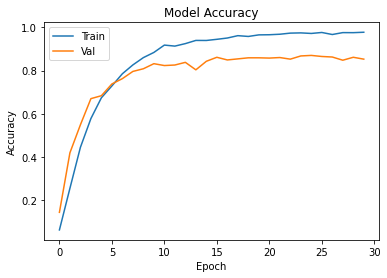

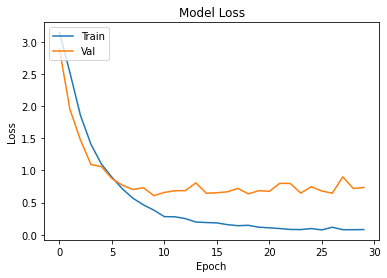

In [31]:
plot_train_history(history)

## Testing the Model

In [32]:
results = model.evaluate(test_generator, batch_size=BATCH_SIZE)

19/19 [==============================] - 5s 253ms/step - loss: 0.7748 - accuracy: 0.8766


The model trained from scratch is able to get to 88% accuracy on the test set, which is pretty good but not very exciting. The training history shows that accuracy on the validation set stopped improving after about 10 epochs while the training accuracy climbed towards 98%.

The Classification Report from Scikit-Learn gives us more detail on the classification accuracy by class.

In [33]:
Y_test = []
for i in range(len(test_generator)):
    for j in test_generator[i][1]:
        Y_test.append(np.argmax(j))
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(classification_report(Y_test, y_pred, target_names=CLASSES))

                   precision    recall  f1-score   support

           bridge       0.88      0.86      0.87        50
              cat       0.89      0.84      0.87        50
            chair       0.93      0.86      0.90        50
           childs       0.73      0.94      0.82        50
       cobraupdog       0.83      0.70      0.76        50
              cow       0.94      0.90      0.92        50
        cranecrow       0.88      0.90      0.89        50
      downwarddog       0.94      0.92      0.93        50
         halfmoon       0.88      0.92      0.90        50
        headstand       0.87      0.96      0.91        50
         mountain       0.90      0.88      0.89        50
            plank       0.91      0.80      0.85        50
           plough       0.92      0.92      0.92        50
seatedforwardfold       0.79      0.76      0.78        50
      seatedmudra       0.87      0.78      0.82        50
        sideangle       0.90      0.88      0.89       

The performance is not equal across classes, with a range of 75% to 95% accuracy (using the F1-score).  Some of this could be due to the imbalanced number of images by class in the training set, or some classes might have had better quality images, or some classes were simply easier to learn.

## Transfer Learning

This next section will import an Inception model pre-trained on the famous ImageNet dataset.  Taking advantage of all the features learned in that pre-training might produce a better classifier for this new task. I learned how to implement this in the DeepLearning.ai course "Convolutional Neural Networks in TensorFlow" offered on Coursera.

In [34]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model with imagenet weights

inception_model = InceptionV3(
                        input_shape =(IMAGE_SIZE, IMAGE_SIZE ,IMAGE_CHAN),
                        include_top = False,
                        weights='imagenet'
                        )

for layer in inception_model.layers:
    layer.trainable = False

last_layer = inception_model.get_layer('mixed7')
last_output = last_layer.output

In [ ]:
# Add new layers to perform classification on the new dataset with number of classes as the last layers outputs
new_top = tf.keras.layers.Flatten()(last_output)
new_top = tf.keras.layers.Dense(1024, activation='relu')(new_top)
new_top = tf.keras.layers.Dropout(0.2)(new_top)                  
new_top = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(new_top)           

pretrained_model = tf.keras.Model(inception_model.input, new_top) 

pretrained_model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# Warning this model summary is very long
# pretrained_model.summary()

In [36]:
%%time
pretrained_hist = pretrained_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[callbacks])

Epoch 1/30
74/74 [==============================] - 67s 855ms/step - loss: 11.1764 - accuracy: 0.3581 - val_loss: 0.4967 - val_accuracy: 0.8556
Epoch 2/30
74/74 [==============================] - 62s 844ms/step - loss: 0.4158 - accuracy: 0.8770 - val_loss: 0.2999 - val_accuracy: 0.8988
Epoch 3/30
74/74 [==============================] - 62s 843ms/step - loss: 0.1582 - accuracy: 0.9509 - val_loss: 0.3038 - val_accuracy: 0.9173
Epoch 4/30
74/74 [==============================] - 63s 850ms/step - loss: 0.1022 - accuracy: 0.9664 - val_loss: 0.2340 - val_accuracy: 0.9370
Epoch 5/30
74/74 [==============================] - 63s 852ms/step - loss: 0.0732 - accuracy: 0.9781 - val_loss: 0.2578 - val_accuracy: 0.9321
Epoch 6/30
74/74 [==============================] - 63s 851ms/step - loss: 0.0452 - accuracy: 0.9863 - val_loss: 0.2038 - val_accuracy: 0.9444
Epoch 7/30
74/74 [==============================] - 63s 852ms/step - loss: 0.0470 - accuracy: 0.9874 - val_loss: 0.2440 - val_accuracy: 0.938

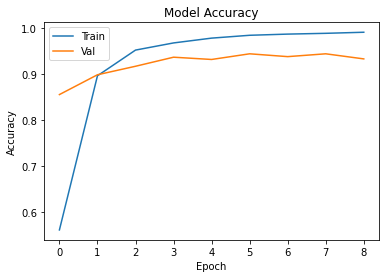

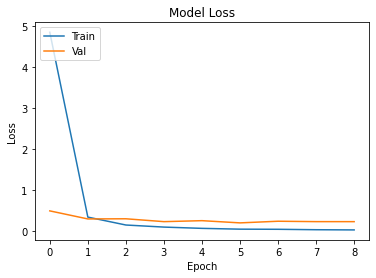

In [37]:
plot_train_history(pretrained_hist)

In [38]:
results = pretrained_model.evaluate(test_generator, batch_size=BATCH_SIZE)

19/19 [==============================] - 5s 262ms/step - loss: 0.2442 - accuracy: 0.9391


In [39]:
Y_test = []
for i in range(len(test_generator)):
    for j in test_generator[i][1]:
        Y_test.append(np.argmax(j))
y_pred = np.argmax(pretrained_model.predict(test_generator), axis=1)
print(classification_report(Y_test, y_pred, target_names=CLASSES))

                   precision    recall  f1-score   support

           bridge       0.92      0.96      0.94        50
              cat       0.91      0.96      0.93        50
            chair       0.98      0.94      0.96        50
           childs       0.90      0.92      0.91        50
       cobraupdog       0.96      0.86      0.91        50
              cow       0.96      0.94      0.95        50
        cranecrow       0.94      1.00      0.97        50
      downwarddog       0.98      0.94      0.96        50
         halfmoon       0.92      0.98      0.95        50
        headstand       0.92      0.98      0.95        50
         mountain       0.88      1.00      0.93        50
            plank       0.87      0.94      0.90        50
           plough       0.96      0.98      0.97        50
seatedforwardfold       0.88      0.92      0.90        50
      seatedmudra       0.98      0.96      0.97        50
        sideangle       0.98      0.84      0.90       

The pretrained InceptionV3 model did a much better job at this classification task, and it took less time to train than the from scratch model. There is variation in the accuracy by class with the pretrained model, but the range is from 88% to 98% accuracy which is significant improvement over the previous model. That's an example of the power of transfer learning, and being able to build on top of state of the art technology. I suspect there were features related to human body parts and various shapes that were useful in the application to yoga poses.

## Conclusion

In this project I demonstrated a standard machine learning workflow with the Keras and TensorFlow frameworks.  I made use of web scraping to collect the data, practiced manual cleaning to improve the quality of the dataset, and built a pipeline to process the images and labels for feeding into a neural network.  I built a fairly simple convolutional neural network architecture for multi-class image classification and trained it from scratch to a decent accuracy. I then used a pretrained Inception model, fine-tuning it on the new dataset and saw improved performance, both in accuracy and total training time.

The dataset size and quality could be better and I could try using a weighted sampling to balance out the number of images seen from each class during training. Further exploration could include testing different architectures to compare performance or implementing a pose estimation model. I would also be curious to explore what kinds of images a Generative Adverserial Network would generate if trained on the yoga poses dataset.

Overall this was a fun and educational exercise. I enjoyed the ease and simplicity of the Keras framework and learned a lot while building the dataset from scratch.